### Ship ML Experiment
Predict gross tonnage of a ship! 

The approach can be divided into a few parts:
1. Explore the dataset and prepare the data 
2. Separate the data into train, validation and test set
3. Find feature importance
4. Create new features
5. Find correct algorithm 
6. Hyperparameter tuning of that algorithm 
7. Test the algorithm 

But first: import all necessary packages!

In [2]:
import sklearn as sk
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np 

## Part 1: explore the dataset and prepare the data
First I explore the dataset a bit. Although the set is small and column names and the number of rows can be seen immediately, I also get numeric values, type of the columns etc. Useful information for manual creation of features. 

I read in the data as a pandas dataframe. A dataframe allows for easy data exploration and data handling (column deletion, insertion etc.)

In [35]:
data = pd.read_csv("ship_data.csv", skiprows= 0)
data.head

<bound method NDFrame.head of        Ship_name Cruise_line  Age  cabins   crew  passengers  length  \
0        Journey     Azamara    6    3.55   3.55        6.94    5.94   
1          Quest     Azamara    6    3.55   3.55        6.94    5.94   
2    Celebration    Carnival   26    7.43   6.70       14.86    7.22   
3       Conquest    Carnival   11   14.88  19.10       29.74    9.53   
4        Destiny    Carnival   17   13.21  10.00       26.42    8.92   
..           ...         ...  ...     ...    ...         ...     ...   
153       Taurus        Star   22    0.33   0.59        0.66    2.79   
154        Virgo        Star   14    9.67  12.00       19.60    8.79   
155       Spirit    Windstar   25    0.74   0.88        1.58    4.40   
156         Star    Windstar   27    0.74   0.88        1.67    4.40   
157         Surf    Windstar   23    1.56   1.80        3.08    6.17   

     passenger_density  gross_tonnage  
0                42.64         30.277  
1                42.64   

In [32]:
# Check for null values 
data[data.isnull().any(axis=1)]


,Ship_name,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage


In [5]:
# Column names 
data.columns

Index(['Ship_name', 'Cruise_line', 'Age', 'cabins', 'crew', 'passengers',
       'length', 'passenger_density', 'gross_tonnage'],
      dtype='object')

In [8]:
# Information on number of columns, column types, number of rows
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   cabins             158 non-null    float64
 4   crew               158 non-null    float64
 5   passengers         158 non-null    float64
 6   length             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   gross_tonnage      158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [10]:
# More information in numbers of the numeric columns. 'Name' is excluded 
data.describe()

,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,8.830000,7.794177,18.457405,8.130633,39.900949,71.284671
std,7.615691,4.471417,3.503487,9.677095,1.793474,8.639217,37.229540
min,4.000000,0.330000,0.590000,0.660000,2.790000,17.700000,2.329000
25%,10.000000,6.132500,5.480000,12.535000,7.100000,34.570000,46.013000
50%,14.000000,9.570000,8.150000,19.500000,8.555000,39.085000,71.899000
75%,20.000000,10.885000,9.990000,24.845000,9.510000,44.185000,90.772500
max,48.000000,27.000000,21.000000,54.000000,11.820000,71.430000,220.000000


## Part 1b: prepare the data 
Before I'll split into train, validation and test set, I have to prepare some features. As we can see in the data, there are numeric features as well as object features. 

One of the features is the name of the ship. Assuming the name is not of importance to the prediction of the gross tonnage, we can leave this feature out of the data. 

Another feature is the "Cruise_line". This might be an important feature, but we do not know that now. 

In [36]:
data = data.drop(columns = ['Ship_name']).copy()

In [37]:
data["Cruise_line"].unique()
len(data["Cruise_line"].unique()) 

20

There are 20 unique values for "Cruise_line". I will make this categorical using Label Encoding. This makes it easier for the model to handle, however it will lose some form of meaning. 

In [38]:
data['Cruise_line'] = data.Cruise_line.astype('category').cat.codes


In [39]:
data.head

<bound method NDFrame.head of      Cruise_line  Age  cabins   crew  passengers  length  passenger_density  \
0              0    6    3.55   3.55        6.94    5.94              42.64   
1              0    6    3.55   3.55        6.94    5.94              42.64   
2              1   26    7.43   6.70       14.86    7.22              31.80   
3              1   11   14.88  19.10       29.74    9.53              36.99   
4              1   17   13.21  10.00       26.42    8.92              38.36   
..           ...  ...     ...    ...         ...     ...                ...   
153           18   22    0.33   0.59        0.66    2.79              50.62   
154           18   14    9.67  12.00       19.60    8.79              39.18   
155           19   25    0.74   0.88        1.58    4.40              33.86   
156           19   27    0.74   0.88        1.67    4.40              32.04   
157           19   23    1.56   1.80        3.08    6.17              47.87   

     gross_tonnage  


## Part 2: split into train, validation and test set
Train and test split as the usual practice, and addition of the validation set for the hyperparameter tuning. I opted for a small validation and test set, as the dataset has only 157 rows with data. 

Even though not completely necessary in a notebook, I've created a small function to return train, val and test set easily. 

In [40]:

def getTrainValTest(X, y, train_part, val_part):

    X_train, X_rest, y_train, y_rest = train_test_split(X,y, train_size=train_part)

    test_part = 1 - train_part - val_part

    X_val, X_test, y_val, y_test = train_test_split(X_rest,y_rest, test_size=test_part)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [43]:
X = data.drop(columns = ['gross_tonnage']).copy()
y = data['gross_tonnage']

X_train, y_train, X_val, y_val, X_test, y_test = getTrainValTest(X,y, 0.8, 0.1)

## Part 3: find feature importance 
From the given list of columns, not all features will be equally important. Keeping all features might result in overfitting, which is why some features are not taken into account for the training of the classifier. 

First we try to get a baseline by using all features and then use a function to calculate their feature importance

Feature: 0, Score: 0.00200
Feature: 1, Score: 0.01204
Feature: 2, Score: 0.30174
Feature: 3, Score: 0.13455
Feature: 4, Score: 0.05335
Feature: 5, Score: 0.49337
Feature: 6, Score: 0.00294


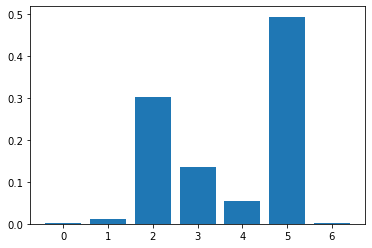

In [44]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

model = RandomForestRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

<AxesSubplot:>

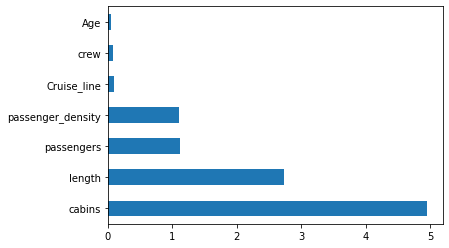

In [59]:
from sklearn.svm import SVR  

model = SVR(kernel = 'linear')

model.fit(X_train, y_train)


pd.Series(abs(model.coef_[0]), index=X_train.columns).nlargest(10).plot(kind='barh')


